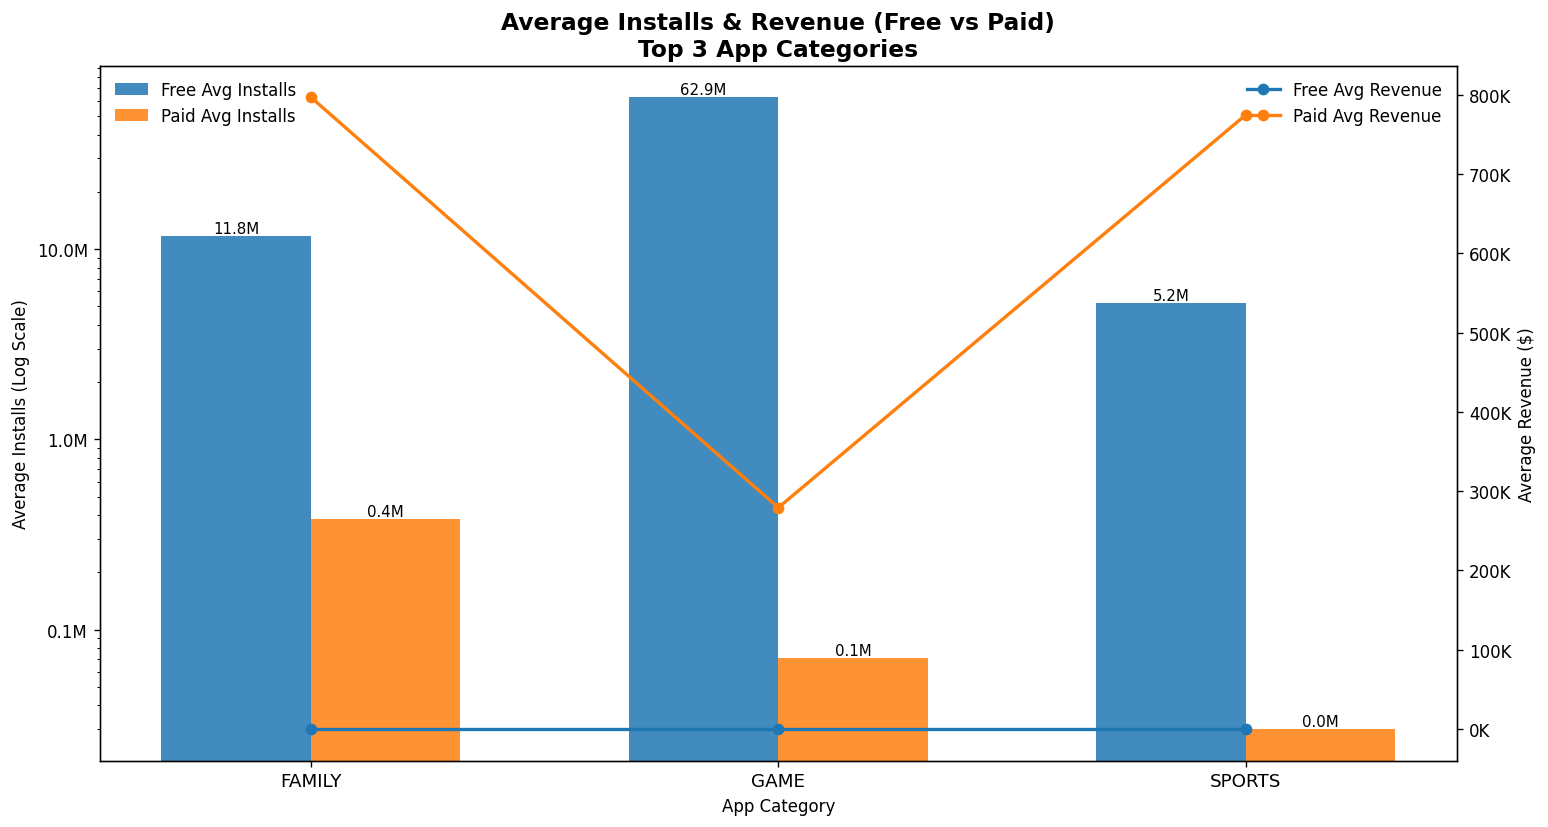

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time
from matplotlib.ticker import FuncFormatter
import pytz

# --- Load and clean data ---
df = pd.read_csv("Play Store Data.csv")

# Clean installs
df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Clean price and compute revenue
df['Price'] = df['Price'].astype(str).str.replace('$', '', regex=False)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Revenue'] = df['Price'] * df['Installs']
df.loc[df['Type'] == 'Free', 'Revenue'] = 0

# Clean size
def clean_size(size):
    if isinstance(size, str):
        size = size.strip()
        if size.endswith('M'):
            return float(size.replace('M',''))
        elif size.endswith('k'):
            return float(size.replace('k','')) / 1024
        elif size.endswith('G'):
            return float(size.replace('G','')) * 1024
    return None

df['Size_MB'] = df['Size'].apply(clean_size)

# Clean Android version
df['Android_Ver_Clean'] = df['Android Ver'].astype(str).str.extract(r'(\d+\.\d+)')
df['Android_Ver_Clean'] = pd.to_numeric(df['Android_Ver_Clean'], errors='coerce')

# App name length
df['App_Length'] = df['App'].astype(str).str.len()

# --- Apply filters ---
filtered_df = df[
    (df['Installs'] >= 10000) &
    (df['Android_Ver_Clean'] > 4.0) &
    (df['Size_MB'] > 15) &
    (df['Content Rating'] == 'Everyone') &
    (df['App_Length'] <= 30)
]

# Free apps always included, Paid apps only if revenue ≥ 10000
filtered_df = filtered_df[
    (filtered_df['Type'] == 'Free') |
    ((filtered_df['Type'] == 'Paid') & (filtered_df['Revenue'] >= 10000))
]

# --- Top 3 categories ---
top_categories = filtered_df['Category'].value_counts().head(3).index
top_df = filtered_df[filtered_df['Category'].isin(top_categories)]

# Group and pivot
grouped = (
    top_df
    .groupby(['Category','Type'])
    .agg({'Installs':'mean','Revenue':'mean'})
    .reset_index()
)

pivot_installs = grouped.pivot(index='Category', columns='Type', values='Installs').fillna(0)
pivot_revenue  = grouped.pivot(index='Category', columns='Type', values='Revenue').fillna(0)

for col in ['Free','Paid']:
    if col not in pivot_installs:
        pivot_installs[col] = 0
    if col not in pivot_revenue:
        pivot_revenue[col] = 0

categories = pivot_installs.index
x = range(len(categories))
width = 0.32

# --- Time restriction (1 PM – 2 PM IST) --- 13 14 
ist = pytz.timezone('Asia/Kolkata')
now = datetime.now(ist).time()
start_time = time(13, 0)
end_time   = time(14, 0)

# Formatters
def millions(x, pos):
    return f'{x/1_000_000:.1f}M'
def thousands(x, pos):
    return f'{x/1_000:.0f}K'

if start_time <= now <= end_time:
    fig, ax1 = plt.subplots(figsize=(13,7), dpi=120)
    ax2 = ax1.twinx()

    # Bars for installs
    free_bars = ax1.bar(
        [i - width/2 for i in x],
        pivot_installs['Free'],
        width=width,
        label='Free Avg Installs',
        alpha=0.85
    )
    paid_bars = ax1.bar(
        [i + width/2 for i in x],
        pivot_installs['Paid'],
        width=width,
        label='Paid Avg Installs',
        alpha=0.85
    )

    ax1.set_yscale('log')
    ax1.yaxis.set_major_formatter(FuncFormatter(millions))
    ax1.set_ylabel("Average Installs (Log Scale)")
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, fontsize=11)
    ax1.set_xlabel("App Category")

    # Lines for revenue
    ax2.plot(x, pivot_revenue['Free'], marker='o', linewidth=2, label='Free Avg Revenue')
    ax2.plot(x, pivot_revenue['Paid'], marker='o', linewidth=2, label='Paid Avg Revenue')
    ax2.yaxis.set_major_formatter(FuncFormatter(thousands))
    ax2.set_ylabel("Average Revenue ($)")

    # Annotate bars
    for bar in free_bars + paid_bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(
                bar.get_x() + bar.get_width()/2,
                height,
                f'{height/1_000_000:.1f}M',
                ha='center',
                va='bottom',
                fontsize=9
            )

    ax1.legend(loc='upper left', frameon=False)
    ax2.legend(loc='upper right', frameon=False)

    plt.title(
        "Average Installs & Revenue (Free vs Paid)\nTop 3 App Categories",
        fontsize=14,
        weight='bold'
    )
    plt.tight_layout()
    plt.show()
else:
    print("⏰ Chart visible only between 1 PM – 2 PM IST")
